In [1]:
import pandas as pd
import numpy as np
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, matthews_corrcoef, brier_score_loss, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.calibration import CalibrationDisplay
from imblearn.over_sampling import RandomOverSampler

In [2]:
faults = pd.read_csv('../data/J1939Faults.csv',low_memory=False)
faults.head()

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25.000
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10.000
2,3,990364,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,False,127,NaN,1369,105336226,41.421250,-87.767361,2015-02-21 11:35:26.000
3,4,990370,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,True,127,NaN,1369,105336226,41.421018,-87.767361,2015-02-21 11:36:08.000
4,5,990416,2015-02-21 11:39:41.000,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,17,False,2,NaN,1674,105427130,38.416481,-89.442638,2015-02-21 11:39:37.000


In [3]:
columns_to_drop = ['ESS_Id', 
                   'actionDescription', 
                   'ecuSoftwareVersion', 
                   'ecuSerialNumber', 
                   'ecuModel', 
                   'ecuMake', 
                   'ecuSource', 
                   'faultValue', 
                   'MCTNumber']

faults_a = faults.drop(columns=columns_to_drop)
faults_a.head()

,RecordID,EventTimeStamp,eventDescription,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp
0,1,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,111,17,True,2,1439,38.857638,-84.626851,2015-02-21 11:34:25.000
1,2,2015-02-21 11:34:34.000,NaN,629,12,True,127,1439,38.857638,-84.626851,2015-02-21 11:35:10.000
2,3,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,1807,2,False,127,1369,41.421250,-87.767361,2015-02-21 11:35:26.000
3,4,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,1807,2,True,127,1369,41.421018,-87.767361,2015-02-21 11:36:08.000
4,5,2015-02-21 11:39:41.000,NaN,4364,17,False,2,1674,38.416481,-89.442638,2015-02-21 11:39:37.000


In [4]:
faults_a['EventTimeStamp'] = pd.to_datetime(faults_a['EventTimeStamp'])
faults_a['LocationTimeStamp'] = pd.to_datetime(faults_a['LocationTimeStamp'])

# Function to split time of day
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

# Apply the function to create a new column for time of day
faults_a['time_of_day'] = faults_a['EventTimeStamp'].dt.hour.apply(categorize_time_of_day)

faults_a['Month'] = faults_a['EventTimeStamp'].dt.month
faults_a['Year'] = faults_a['EventTimeStamp'].dt.year

In [5]:
equipment_list = faults_a['EquipmentID'].unique().tolist()

In [6]:
diagnostics = pd.read_csv("../data/VehicleDiagnosticOnboardData.csv")
diagnostics.head()

,Id,Name,Value,FaultId
0,1,IgnStatus,False,1
1,2,EngineOilPressure,0,1
2,3,EngineOilTemperature,96.74375,1
3,4,TurboBoostPressure,0,1
4,5,EngineLoad,11,1


In [7]:
diagnostics_pivoted = diagnostics.pivot(index='FaultId', columns='Name', values='Value')
diagnostic_name_list = diagnostics_pivoted.columns.tolist()
print(diagnostic_name_list)
diagnostics_pivoted.head()

['AcceleratorPedal', 'BarometricPressure', 'CruiseControlActive', 'CruiseControlSetSpeed', 'DistanceLtd', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature', 'IgnStatus', 'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake', 'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure']


Name,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
FaultId,,,,,,,,,,,,,,,,,,,,,
1,0,14.21,False,66.48672,423178.7,100.4,11,0,96.74375,0,...,NaN,False,78.8,1023,True,NaN,0,3276.75,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16639,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
faults_diagnostics = pd.merge(faults_a, diagnostics_pivoted, 
                        left_on='RecordID',right_on= 'FaultId',how='left')

faults_diagnostics.head()

,RecordID,EventTimeStamp,eventDescription,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
0,1,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,111,17,True,2,1439,38.857638,-84.626851,...,NaN,False,78.8,1023,True,NaN,0,3276.75,NaN,0
1,2,2015-02-21 11:34:34,NaN,629,12,True,127,1439,38.857638,-84.626851,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2015-02-21 11:35:31,Incorrect Data Steering Wheel Angle,1807,2,False,127,1369,41.421250,-87.767361,...,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,1807,2,True,127,1369,41.421018,-87.767361,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2015-02-21 11:39:41,NaN,4364,17,False,2,1674,38.416481,-89.442638,...,NaN,NaN,NaN,16639,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Switched to get_dummies approach later, so this is commented out now!

faults_diagnostics= faults_diagnostics[faults_diagnostics['active']==True]
# #Full Derate
# faults_diagnostics['IsSpn5246'] = np.where(faults_diagnostics['spn']==5246,True,False)
# #Low Engine Coolant Level
# faults_diagnostics['IsSpn111'] = np.where(faults_diagnostics['spn']==111,True,False)
# #Condition Exists Engine Protection Torque Derate
# faults_diagnostics['IsSpn1569'] = np.where(faults_diagnostics['spn']==1569,True,False)
# #Low Voltage (Aftertreatment 1 Outlet NOx)
# faults_diagnostics['IsSpn3226'] = np.where(faults_diagnostics['spn']==3226,True,False)

# #print(faults_diagnostics[faults_diagnostics['IsSpn5246']==True].shape)
# #faults_diagnostics[faults_diagnostics['EquipmentID']=='1395'].tail(50)
# faults_diagnostics.head()

In [10]:
#In (lat, lon) format

#Mt Juliet Location: (36.0666667, -86.4347222)
#(36.2115942, -86.4347222) #10 miles North
#(35.9217392, -86.4347222) #10 miles South
#(36.0666667, -86.305976) #10 miles East
#(36.0666667, -86.563468) #10 miles West

#Shelbyville location: (35.588333, -86.443888)
#North: (35.6382021, -86.443888)
#South: (35.5384639, -86.443888)
#East: (35.588333, -86.3391842)
#West: (35.588333, -86.5485918)

#Russellville location: (36.1950, -83.174722)
#North: (36.2374703, -83.174722)
#South: (36.1525297, -83.174722)
#East: (36.195, -83.0693852)
#West: (36.195, -83.2800588)

faults_diagnostics_noservice = faults_diagnostics[~(
                    ((faults_diagnostics['Latitude'] > 35.9217392) & (faults_diagnostics['Latitude'] < 36.2115942) & 
                    (faults_diagnostics['Longitude'] > -86.5485918) & (faults_diagnostics['Longitude'] < -86.305976)) |
                    
                    ((faults_diagnostics['Latitude'] > 35.5384639) & (faults_diagnostics['Latitude'] < 35.6382021) & 
                    (faults_diagnostics['Longitude'] > -86.5485918) & (faults_diagnostics['Longitude'] < -86.3391842)) |
                    
                    ((faults_diagnostics['Latitude'] > 36.1525297) & (faults_diagnostics['Latitude'] < 36.2374703) & 
                    (faults_diagnostics['Longitude'] > -83.2800588) & (faults_diagnostics['Longitude'] < -83.0693852))
                                                   )]
print(faults_diagnostics.shape)
print(faults_diagnostics_noservice.shape)
faults_diagnostics_noservice.head()

(608454, 38)
(533581, 38)


,RecordID,EventTimeStamp,eventDescription,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
0,1,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,111,17,True,2,1439,38.857638,-84.626851,...,NaN,False,78.8,1023,True,NaN,0,3276.75,NaN,0
1,2,2015-02-21 11:34:34,NaN,629,12,True,127,1439,38.857638,-84.626851,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,1807,2,True,127,1369,41.421018,-87.767361,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2015-02-21 11:40:22,Low (Severity Low) Engine Coolant Level,111,17,True,1,1417,33.043564,-96.179722,...,NaN,True,111.2,1023,NaN,NaN,13.6022,3276.75,NaN,6.67
6,7,2015-02-21 11:40:52,Low (Severity Low) Engine Coolant Level,111,17,True,2,1597,36.902916,-86.436481,...,NaN,True,78.8,1023,NaN,NaN,41.53478,3276.75,NaN,20.59


In [11]:
faults_diagnostics_noservice.sort_values(by = ['EquipmentID', 'EventTimeStamp'], ascending = True).head(30)

,RecordID,EventTimeStamp,eventDescription,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
1001106,1038243,2018-07-20 09:31:33,High (Severity Medium) J1939 Network #2,1231,16,True,2,0105406655,36.139351,-85.629722,...,NaN,True,138.2,255,False,NaN,5.203984,NaN,100,5.8
358800,366301,2016-01-31 07:12:25,NaN,629,12,True,127,105301976,41.987175,-87.731990,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
927313,955890,2018-01-26 18:58:08,Low (Severity Medium) Transmission Air Tank Pr...,37,18,True,1,105338729,38.348564,-85.709120,...,NaN,True,120.2,50175,False,NaN,0,NaN,100,0.29
936445,965022,2018-02-12 20:29:39,NaN,5939,16,True,3,105338729,39.953425,-81.935462,...,NaN,True,114.8,50175,False,NaN,0,NaN,100,1.16
936451,965028,2018-02-12 20:33:23,NaN,5939,0,True,1,105338729,39.953379,-81.935416,...,NaN,True,109.4,50175,False,NaN,0.2815588,NaN,100,0.29
938572,967149,2018-02-15 21:21:55,Low (Severity Medium) Transmission Air Tank Pr...,37,18,True,4,105338729,29.806388,-95.275648,...,NaN,True,125.6,50175,False,NaN,0,NaN,100,1.16
956597,986123,2018-03-20 19:04:20,Incorrect Data Wheel Sensor ABS Axle 2 Right,792,2,True,1,105338729,38.797916,-77.586481,...,NaN,True,80.6,51199,False,NaN,62.39926,NaN,100,26.39
957052,986578,2018-03-21 14:04:57,Incorrect Data Wheel Sensor ABS Axle 2 Right,792,2,True,3,105338729,38.921435,-77.216759,...,NaN,True,84.2,51199,False,NaN,55.27291,NaN,100,14.79
957187,986713,2018-03-21 19:10:37,Low (Severity Medium) Transmission Air Tank Pr...,37,18,True,5,105338729,37.720138,-77.116620,...,NaN,True,89.6,50175,False,NaN,2.572865,NaN,100,1.16
957913,987439,2018-03-23 08:17:23,Low (Severity Medium) Transmission Air Tank Pr...,37,18,True,6,105338729,40.478796,-76.304722,...,NaN,True,82.4,50175,False,NaN,0.8446764,NaN,100,0.29


In [12]:
#faults_diagnostics.to_csv('../data/faults_diagnostics.csv')
#faults_diagnostics_noservice.to_csv('../data/faults_diagnostics_no_service_stations.csv')

In [13]:
#faults_diagnostics_noservice.dtypes
#faults_diagnostics_noservice.set_index('EventTimeStamp').rolling(5, on='EquipmentID', min_periods=0).sum().reset_index()
#faults_diagnostics_noservice.rolling('5D', on='spn')
faults_diagnostics_noservice.sort_values(['EventTimeStamp']).groupby(['EquipmentID']).rolling('5D', on='EventTimeStamp', min_periods=0).sum().head()

C:\Users\Alex Balli\AppData\Local\Temp\ipykernel_19904\2508329469.py:4: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['AcceleratorPedal', 'BarometricPressure', 'CruiseControlActive',
       'DistanceLtd', 'EngineCoolantTemperature', 'EngineOilPressure',
       'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel',
       'FuelLtd', 'FuelRate', 'FuelTemperature', 'IgnStatus',
       'IntakeManifoldTemperature', 'LocationTimeStamp', 'ParkingBrake',
       'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure',
       'eventDescription', 'time_of_day'],
      dtype='object')
  faults_diagnostics_noservice.sort_values(['EventTimeStamp']).groupby(['EquipmentID']).rolling('5D', on='EventTimeStamp', min_periods=0).sum().head()


CruiseControlSetSpeed      EventTimeStamp  EngineLoad  \
EquipmentID                                                                  
0105406655  1001106                    0.0 2018-07-20 09:31:33        12.0   
105301976   358800                     0.0 2016-01-31 07:12:25         0.0   
105338729   927313                     0.0 2018-01-26 18:58:08        16.0   
            936445                     0.0 2018-02-12 20:29:39        49.0   
            936451                     0.0 2018-02-12 20:33:23        86.0   

                     LampStatus   Latitude   Longitude  Month   RecordID  \
EquipmentID                                                                
0105406655  1001106       255.0  36.139351  -85.629722    7.0  1038243.0   
105301976   358800       1279.0  41.987175  -87.731990    1.0   366301.0   
105338729   927313      50175.0  38.348564  -85.709120    1.0   955890.0   
            936445      50175.0  39.953425  -81.935462    2.0   965022.0   
            936451     100350.0  79.906804 -163.870878    4.0  1930050.0   

                     ServiceDistance    Year  active  activeTransitionCount  \
EquipmentID                                                                   
0105406655  1001106              0.0  2018.0     1.0                    2.0   
105301976   358800               0.0  2016.0     1.0                  127.0   
105338729   927313               0.0  2018.0     1.0                    1.0   
            936445               0.0  2018.0     1.0                    3.0   
            936451               0.0  4036.0     2.0                    4.0   

                      fmi      spn  
EquipmentID                         
0105406655  1001106  16.0   1231.0  
105301976   358800   12.0    629.0  
105338729   927313   18.0     37.0  
            936445   16.0   5939.0  
            936451   16.0  11878.0

In [14]:
#Would a onehotencoder or pd.get_dummies approach with 418 new columns make sense?
spn_list = faults_diagnostics_noservice['spn'].unique().tolist()
#spn_list_string = list(map(str, spn_list))
print(len(spn_list))

418


In [15]:
faults_diagnostics_noservice_spndummies = pd.concat((faults_diagnostics_noservice,pd.get_dummies(faults_diagnostics_noservice['spn'])),1)
faults_diagnostics_noservice_spndummies.head()

C:\Users\Alex Balli\AppData\Local\Temp\ipykernel_19904\2424683490.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  faults_diagnostics_noservice_spndummies = pd.concat((faults_diagnostics_noservice,pd.get_dummies(faults_diagnostics_noservice['spn'])),1)


,RecordID,EventTimeStamp,eventDescription,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,...,520413,520953,521032,523530,523531,523543,524033,524037,524071,524287
0,1,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,111,17,True,2,1439,38.857638,-84.626851,...,0,0,0,0,0,0,0,0,0,0
1,2,2015-02-21 11:34:34,NaN,629,12,True,127,1439,38.857638,-84.626851,...,0,0,0,0,0,0,0,0,0,0
3,4,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,1807,2,True,127,1369,41.421018,-87.767361,...,0,0,0,0,0,0,0,0,0,0
5,6,2015-02-21 11:40:22,Low (Severity Low) Engine Coolant Level,111,17,True,1,1417,33.043564,-96.179722,...,0,0,0,0,0,0,0,0,0,0
6,7,2015-02-21 11:40:52,Low (Severity Low) Engine Coolant Level,111,17,True,2,1597,36.902916,-86.436481,...,0,0,0,0,0,0,0,0,0,0


In [16]:
final_columns = ['EventTimeStamp', 'EquipmentID', *spn_list]
faults_diagnostics_noservice_spnrolling = faults_diagnostics_noservice_spndummies[final_columns].sort_values(['EventTimeStamp']).groupby(['EquipmentID']).rolling('5D', on='EventTimeStamp', min_periods=0).sum().reset_index()
#Not sure what this "level_1" column is, but everything else seems great!


#Changing Full derate column to only have "1" if true or "0" if false instead of a sum
faults_diagnostics_noservice_spnrolling[5246] = np.where(faults_diagnostics_noservice_spnrolling[5246]>0,1,0)

In [17]:
faults_diagnostics_noservice_spndummies[final_columns].head()

,EventTimeStamp,EquipmentID,111,629,1807,97,1067,96,829,596,...,335040,520200,7323,88121,153931,13600,767,603,577,5953
0,2015-02-21 10:47:13,1439,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2015-02-21 11:34:34,1439,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2015-02-21 11:35:33,1369,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2015-02-21 11:40:22,1417,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2015-02-21 11:40:52,1597,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
faults_diagnostics_noservice_spndummies[faults_diagnostics_noservice_spndummies['EquipmentID']=='0105406655']

,RecordID,EventTimeStamp,eventDescription,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,...,520413,520953,521032,523530,523531,523543,524033,524037,524071,524287
1001106,1038243,2018-07-20 09:31:33,High (Severity Medium) J1939 Network #2,1231,16,True,2,0105406655,36.139351,-85.629722,...,0,0,0,0,0,0,0,0,0,0


In [19]:
faults_diagnostics_noservice_spnrolling.head()

,EquipmentID,level_1,EventTimeStamp,0,16,27,33,37,38,51,...,520413,520953,521032,523530,523531,523543,524033,524037,524071,524287
0,0105406655,1001106,2018-07-20 09:31:33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,105301976,358800,2016-01-31 07:12:25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,105338729,927313,2018-01-26 18:58:08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,105338729,936445,2018-02-12 20:29:39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,105338729,936451,2018-02-12 20:33:23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
predictors = spn_list.copy()
predictors.remove(5246)
X = faults_diagnostics_noservice_spnrolling[predictors]
y = faults_diagnostics_noservice_spnrolling[5246]
print(len(predictors))
print(len(spn_list))

417
418


In [21]:
y.value_counts()

0    530432
1      3149
Name: 5246, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)

In [23]:
rf = RandomForestClassifier(max_depth = 5).fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f'Test Set Accuracy: {accuracy_score(y_test, y_pred)}\n')
print(f'MCC: {matthews_corrcoef(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test Set Accuracy: 0.9949173888272512

MCC: 0.37120899069459645
[[132609      0]
 [   678    109]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    132609
           1       1.00      0.14      0.24       787

    accuracy                           0.99    133396
   macro avg       1.00      0.57      0.62    133396
weighted avg       0.99      0.99      0.99    133396



In [24]:
importances = pd.DataFrame({
    'variable': predictors,
    'importance': rf.feature_importances_
})

importances.sort_values('importance', ascending = False).head(20)

#probably overfit. Ideas for next steps: 
#1) cut down on predictors
#2) use decision tree model to help visualize and formalize decision maaking for an average user.
#3) use overfitting methods that Michael described on 4/16/24

,variable,importance
115,5742,0.081404
207,524287,0.075878
10,1569,0.070184
44,5743,0.060203
25,3226,0.059356
81,4094,0.056495
59,3362,0.054052
58,4334,0.048203
20,790,0.039212
144,5394,0.036212


In [25]:
oversampler = RandomOverSampler(random_state = 321)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
y_resampled.value_counts()

0    397823
1    397823
Name: 5246, dtype: int64

In [26]:
rf_oversample = rf.fit(X_resampled, y_resampled)

y_pred = rf_oversample.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred)}')
conf_mat_array = confusion_matrix(y_test, y_pred)
print(conf_mat_array)
print(classification_report(y_test, y_pred))

TN = conf_mat_array[0][0]
FN = conf_mat_array[1][0]
FP = conf_mat_array[0][1]
TP = conf_mat_array[1][1]
savings = (4000 * TP) - (500 * FP)
print(f'The savings from this model was ${savings}')

Accuracy: 0.974032204863714
MCC: 0.3801529546116233
[[129241   3368]
 [    96    691]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    132609
           1       0.17      0.88      0.29       787

    accuracy                           0.97    133396
   macro avg       0.58      0.93      0.64    133396
weighted avg       0.99      0.97      0.98    133396

The savings from this model was $1080000


In [27]:
importances = pd.DataFrame({
    'variable': predictors,
    'importance': rf_oversample.feature_importances_
})

importances.sort_values('importance', ascending = False).head(20)

,variable,importance
10,1569,0.178878
59,3362,0.063520
8,929,0.061230
115,5742,0.048995
25,3226,0.041970
39,3216,0.041563
44,5743,0.038942
21,789,0.035722
93,3031,0.033279
144,5394,0.031921


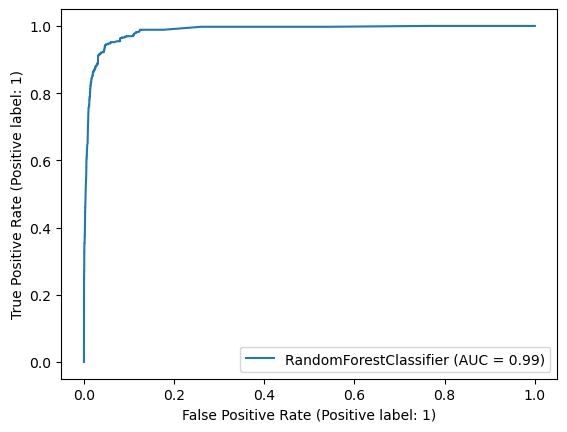

In [28]:
RocCurveDisplay.from_estimator(rf, X_test, y_test);

In [29]:
print(TN, FN, FP, TP)
print((TN+TP)/(TN+FN+FP+TP))

129241 96 3368 691
0.974032204863714


In [30]:
savings = (4000 * TP) - (500 * FP)
print(savings)

1080000


In [31]:
dt_oversample = DecisionTreeClassifier(max_depth=2).fit(X_resampled, y_resampled)
y_pred = dt_oversample.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred)}')
conf_mat_array = confusion_matrix(y_test, y_pred)
print(conf_mat_array)
print(classification_report(y_test, y_pred))

TN = conf_mat_array[0][0]
FN = conf_mat_array[1][0]
FP = conf_mat_array[0][1]
TP = conf_mat_array[1][1]
savings = (4000 * TP) - (500 * FP)
print(f'The savings from this model was ${savings}')

Accuracy: 0.9709886353413896
MCC: 0.3515693706935977
[[128857   3752]
 [   118    669]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    132609
           1       0.15      0.85      0.26       787

    accuracy                           0.97    133396
   macro avg       0.58      0.91      0.62    133396
weighted avg       0.99      0.97      0.98    133396

The savings from this model was $800000


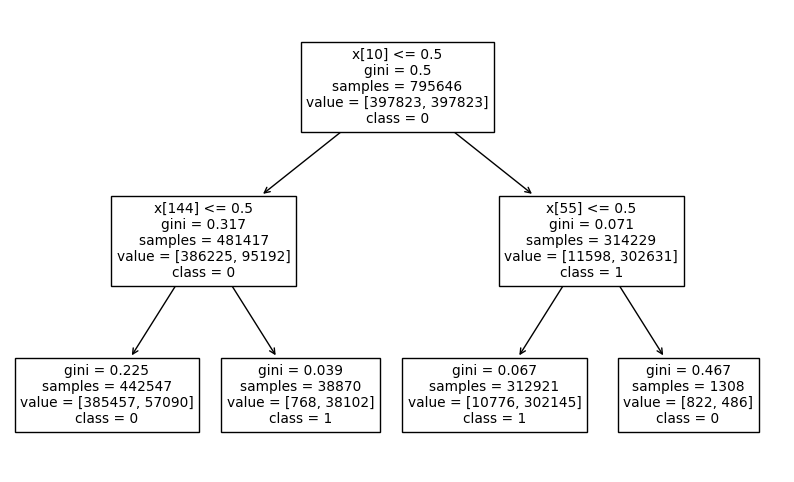

In [36]:
plt.figure(figsize = (10,6))

plot_tree(dt_oversample, class_names = ["0", "1"]);